# A story about a large dataset - Kaggle's Springleaf customer case study

A vast majority of machine learning problems, for example on Kaggle platform, are based on dataset with small number of features (<50) whose description helps to conduct a meaningful exploratory data analysis, data engineering and modelling. Bulding a model for such problems seems relatively straighforward. A model training, including hyperparameter tuning, goes typically pretty fast. But how does this situation change if the dataset is very large and contains thousands of features that in addition are anonymized due to privacy considerations? Can we still preform a meaningful data analysis and constuct a robust model based on a very limited domain knowledge? Does the large number of features introduce additonal challenge for computing time? 

We tried to answer these questions by studying the [Springleaf customer marketing response](https://www.kaggle.com/c/springleaf-marketing-response/overview) dataset from Kaggle. The Springleaf company  offers personal and auto loans and needs to narrow their list customers to those who will respond to their direct mail offer. The company's dataset contains historical information about their 145,000 customers, each described by 2,000 anonymized features. The machine learning model is based on binary classification. About 23\% of historical customers responded to the offer that was sent to them.


As a starting point in the data exploration, we divided the features into three classes following feature types: out of 1932 feaures, about 1400 are numerical integers, 480 are numerical floats, and 50 are recorder as strings (predominantly categorical and datetime features). We performed exploratory data analysis in each of the 3 classes separately. 

Missing values. Numerical integer features (Sec. 3) do not contain any missing numbers and are good to be injected into a machine learning model. In contrast, numerical float features (Sec. 4) and string or categorical features contain missing numbers that required extra studies. About 10 out of 480 float features miss information for more than 60\% of customers (Sec 4.1), however this information differ among customers who accepted and rejected the offer, hence it might be useful to enhance the model performance. As a result, rather than removing these features, we decided to replace the missing values for a given feature by the minimum calculated for all the customers. Similarly, 15 out of 50 string features have large number of missing values (again for at least 60\% of customers) that differ beetwen customers who responed to or ignored the email. Again, rather than removing them we decied to treat then as an extra value for these categorical features. 

Feature engineering. Only string variables require feature engineering see Sec. 5.3. In general, we found that most of the string features are described by a low number of unique values and can be coverted to numerical values by label or one hot encoding. One feature corresond to about 50 labels describing US states, which could be treated in a similar way. A features contain datetime data and can be converted into year, month, day of the month, day of the week etc. One feaure contains more than 12k names of US locations (cities/towns). With an additional information about their population from CENSUS one could convert those fields into just a few corresponding to different city/town sizes. Two features list various profession/position names and have a few hundred unique values, respectively. Most of the professions are listed only once or twice, hence settining a threshold on the minimal number of apperences could limit the number of labels to not more than 100 or 150.

Model building and hyperparameter tuning. We decieded to start with the Random Forest model, which we run on numbercal integer and float numbers. Unfortunately the hyperparameter tuning in many dimentions is pretty time consuming, one would need to perform one-dimensional scans separately for each of the parameter.

Dimentionality reduction is possible, using feature importances and PCA analysis we came to conclusion that the feature dimensions could be reduced from 1,400 to 400 variables for integers, and from 480 to 270 for floats. 

Validation. It's a Kaggle competions. Running only of numerical float features give the AUC prediction score of 0.76, which is very promising given the highest score achived for that competion was 0.82.



* [1. Introduction](#1_introduction)
* [2. Dataset](#2_dataset)
* [3. Numerical features / integers](#3_numercal_ints)
    * [3.1 Missing values](#3.1_nulls)
    * [3.2 Unique values](#3.2_uniques)
    * [3.3 How symmetric are the distributions?](#3.3_symmetric)
    * [3.4 Random Forest Classifier](#3.4_rf)
        * [3.4.1 Feature importance](#3.4.1_fi)
        * [3.4.2 PCA](#3.4.2_pca)
    * [3.5 XGBoost Classifier](#3.5_xgb')
* [4. Numerical features / floats](#4_numerical_floats)
    * [4.1 Missing values](#4.1_nulls)
    * [4.2 Unique values](#4.2_uniques)
    * [4.3 Feature engineering (floats)](#4.3_fi)
    * [4.4 Random Forest Classifier](#4.4_rf)
        * [4.4.1 Feature importance](#4.4.1_fi)
        * [4.4.2 PCA](#4.4.2_pca)
        * [4.4.3 Kolmogorov-Smirnov test](#4.4.3_ks_test)
        * [4.4.4 Correlation matrix](#4.4.4_corr)
* [5. Categorical features](#5_categorical)
    * [5.1 Missing values](#5.1_nulls)
    * [5.2 Unique values](#5.2_uniques)
    * [5.3 Feature engineering (strings)](#5.3_fi)

## 1. Introduction <a id='1_introduction'></a>

The dataset is desribed above. Let's load needed libraries here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import colors 

## 2. Dataset <a id='2_dataset'></a>

In [2]:
df_all = pd.read_csv("./train.csv",index_col='ID',na_values=['NaN','nan'],low_memory=False)
dt_all = pd.read_csv("./test.csv" ,index_col='ID',na_values=['NaN','nan'],low_memory=False)

In [3]:
df_all.shape

(145231, 1933)

In [4]:
dt_all.shape

(145232, 1932)

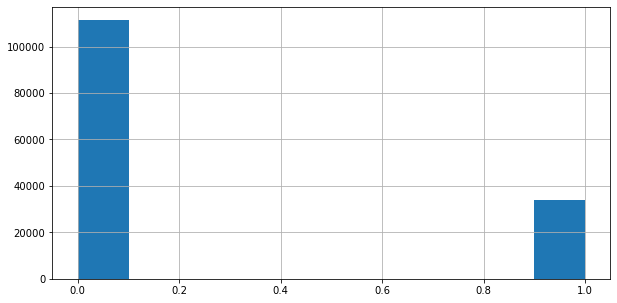

In [208]:
df_all['target'].hist(figsize=(10,5));

In [5]:
df_all.dtypes.value_counts()

int64      1405
float64     477
object       51
dtype: int64

In [6]:
dt_all.dtypes.value_counts()

int64      1404
float64     477
object       51
dtype: int64

As we will see later, those 3 data types have ....

## 3. Numerical features / integers <a id='3_numerical_ints'></a>

In [7]:
dfi = df_all.select_dtypes(include='int')
dfi.shape

(145231, 1405)

### 3.1 Missing values <a id='3.1_nulls'></a>

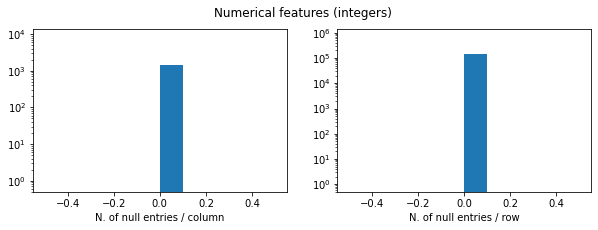

In [89]:
# for columns - sum over rows
# for rows - sum over columns
c= dfi.isna().sum(axis=0)/dfi.shape[0]
r= dfi.isna().sum(axis=1)/dfi.shape[1]

fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(c) 
ax[1].hist(r)

fig.suptitle('Numerical features (integers)')
ax[0].set_yscale('log'); ax[0].set_ylim((0.5,len(c)*10)); ax[0].set_xlabel('N. of null entries / column')
ax[1].set_yscale('log'); ax[1].set_ylim((0.5,len(r)*10)); ax[1].set_xlabel('N. of null entries / row');

Very good, there are no missing values in this class. Let's move to the next step and inspect the structure of the data by looking at multiplicities of unique values per feature.

### 3.2 Unique values <a id='3.2_uniques'></a>

In [9]:
nuni = []
nuni_dic = {}

for col in dfi.columns:
    
    nuni.append(dfi[col].nunique(dropna=False))
    nuni_dic[col] = dfi[col].nunique(dropna=False)
    
pd.Series(nuni_dic).sort_values(ascending=False)

VAR_0899    82419
VAR_0543    81073
VAR_1087    79850
VAR_1082    75972
VAR_1180    75583
            ...  
VAR_0566        2
VAR_0563        2
VAR_0924        2
VAR_1428        1
VAR_0847        1
Length: 1405, dtype: int64

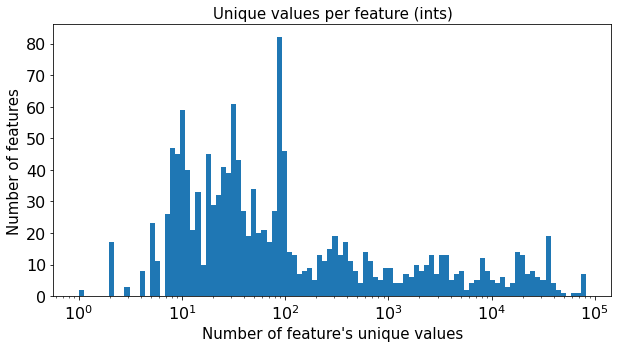

In [10]:
plt.figure(figsize=(10,5))

# with plotting
#hist, bins, _ = plt.hist(nuni, bins=100)
# w/o plotting
hist, bins= np.histogram(nuni, bins=100)
logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))

#plt.subplot(121)
plt.hist(nuni, bins=logbins)
plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Unique values per feature (ints)",fontsize=15)
plt.xlabel("Number of feature's unique values",fontsize=15)
plt.ylabel("Number of features",fontsize=15)
plt.show()

Interesting. A few features have just one unique value, some of them have 2, 3, etc unique values, there are also those with more than 1k values. The higher values correspond to continueous variables, which is good, but let's inspect a few of those with low multiplicities.

In [11]:
i1 = []
i2 = []
i3 = []
i4 = []
i5 = []
i6 = []

for k,v in nuni_dic.items():
    
    if(v==1): i1.append(k)
    elif (v==2): i2.append(k)
    elif (v==3): i3.append(k)
    elif (v==4): i4.append(k)
    elif (v==5): i5.append(k)  
    elif (v==6): i6.append(k)

In [12]:
for v in i1:
    print(dfi[v].value_counts(dropna=False),'\n ---')

1    145231
Name: VAR_0847, dtype: int64 
 ---
0    145231
Name: VAR_1428, dtype: int64 
 ---


In [13]:
for v in i2:
    print(dfi[v].value_counts(dropna=False),'\n ---')

0    140501
1      4730
Name: VAR_0563, dtype: int64 
 ---
0    121232
1     23999
Name: VAR_0566, dtype: int64 
 ---
0    143064
1      2167
Name: VAR_0567, dtype: int64 
 ---
-99999    74801
 0        70430
Name: VAR_0732, dtype: int64 
 ---
 0        110393
-99999     34838
Name: VAR_0733, dtype: int64 
 ---
 0        92376
-99999    52855
Name: VAR_0736, dtype: int64 
 ---
-99999    81544
 0        63687
Name: VAR_0737, dtype: int64 
 ---
 0        112352
-99999     32879
Name: VAR_0739, dtype: int64 
 ---
0    118217
1     27014
Name: VAR_0740, dtype: int64 
 ---
0    141328
1      3903
Name: VAR_0741, dtype: int64 
 ---
0    144760
1       471
Name: VAR_0924, dtype: int64 
 ---
0    119058
1     26173
Name: VAR_1162, dtype: int64 
 ---
0    120946
1     24285
Name: VAR_1163, dtype: int64 
 ---
0    144409
1       822
Name: VAR_1164, dtype: int64 
 ---
0    144165
1      1066
Name: VAR_1165, dtype: int64 
 ---
0    145145
1        86
Name: VAR_1427, dtype: int64 
 ---
0    111458


In [14]:
for v in i3:
    print(dfi[v].value_counts(dropna=False),'\n ---')

0    140366
1      4715
9       150
Name: VAR_0923, dtype: int64 
 ---
0     138276
1       6354
99       601
Name: VAR_1175, dtype: int64 
 ---
0     132944
1      11686
99       601
Name: VAR_1176, dtype: int64 
 ---


In [15]:
for v in i4:
    print(dfi[v].value_counts(dropna=False),'\n ---')

-99999    131353
 0         11265
 1          2560
 2            53
Name: VAR_0809, dtype: int64 
 ---
0     143396
1       1177
99       601
2         57
Name: VAR_0994, dtype: int64 
 ---
0     144449
99       601
1        175
2          6
Name: VAR_1012, dtype: int64 
 ---
0     144393
99       601
1        225
2         12
Name: VAR_1013, dtype: int64 
 ---
0    135438
1      9163
2       587
3        43
Name: VAR_1557, dtype: int64 
 ---
0    127972
1     17166
2        92
3         1
Name: VAR_1562, dtype: int64 
 ---
0     144252
99       601
1        359
2         19
Name: VAR_1590, dtype: int64 
 ---
998    143814
1         739
999       601
400        77
Name: VAR_1849, dtype: int64 
 ---


In [16]:
for v in i5:
    print(dfi[v].value_counts(dropna=False),'\n ---')

98    131582
0      12683
99       601
1        352
2         13
Name: VAR_0637, dtype: int64 
 ---
98    131582
97      8396
0       4583
99       601
1         69
Name: VAR_0639, dtype: int64 
 ---
98    131582
97      8396
0       4607
99       601
1         45
Name: VAR_0640, dtype: int64 
 ---
-99999    109735
 0         33149
 1          2284
 2            61
 3             2
Name: VAR_0745, dtype: int64 
 ---
-99999    131353
 0          7440
 1          6168
 2           265
 3             5
Name: VAR_0799, dtype: int64 
 ---
-99999    131353
 0          9514
 1          4238
 2           125
 3             1
Name: VAR_0804, dtype: int64 
 ---
0     142443
1       2085
99       601
2         98
3          4
Name: VAR_0995, dtype: int64 
 ---
0     141946
1       2554
99       601
2        121
3          9
Name: VAR_1050, dtype: int64 
 ---
0     142769
1       1774
99       601
2         84
3          3
Name: VAR_1051, dtype: int64 
 ---
0     108943
98     30767
1       4834
9

In [17]:
for v in i6:
    print(dfi[v].value_counts(dropna=False),'\n ---')

-99999    109735
 0         31739
 1          3577
 2           173
 3             6
 4             1
Name: VAR_0735, dtype: int64 
 ---
-99999    109735
 0         32832
 1          2570
 2            87
 3             6
 4             1
Name: VAR_0763, dtype: int64 
 ---
0     144034
99       601
1        576
2         18
9          1
3          1
Name: VAR_1055, dtype: int64 
 ---
0    128232
1     14752
2      1899
3       296
4        42
5        10
Name: VAR_1558, dtype: int64 
 ---
98    82186
0     60419
1      1949
99      601
2        73
3         3
Name: VAR_1586, dtype: int64 
 ---
98    84787
0     58055
1      1759
99      601
2        28
3         1
Name: VAR_1663, dtype: int64 
 ---
98    84787
0     37446
97    22140
99      601
1       256
2         1
Name: VAR_1671, dtype: int64 
 ---
98    84787
0     57867
1      1950
99      601
2        25
4         1
Name: VAR_1679, dtype: int64 
 ---
98    84787
0     35533
97    22140
1      2146
99      601
2        24
Name: 

Features VAR_0847 and VAR_1428 have only one value (0 or 1) and we will remove them from the dataset before training. A few features have only two values of 0 and 1, most likely logical. The others seem to describe some sort of ordering or classification, but in addition to (ordered) lowest positive integers (0, 1, 2, 3, etc.), there also show values as large as 98, 99, 999, -99999. These could correspond to some sort of missing information. In general, the distributions within these features are discrete and pretty unbalanced. This implies that the safest machine learning mode to be considered for classification should be based on Decision Trees, such as Random Forest Classifier, of XGBoost Classifier. We will later consider those, but first let's also briefly inspect remaining features.

### 3.3 How symmetric are the distributions? <a id='3.3_symmetric'></a>

In [18]:
cols = dfi.columns

#mean and median normalized to a spectrum range, symmetric at 0.5.
m = []
md = []

for col in cols:
    if dfi[col].nunique() > 1:
        
        mi = dfi[col].min()
        ma = dfi[col].max()
        
        m.append(  (dfi[col].mean()  -  mi)/(ma - mi) )
        md.append( (dfi[col].median() - mi)/(ma - mi) )

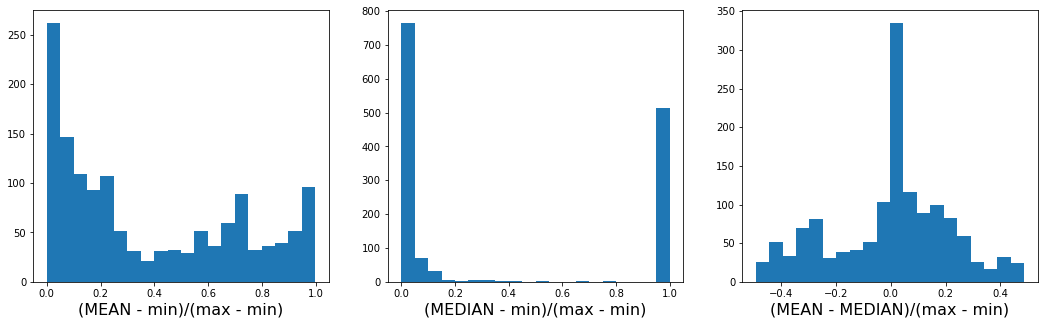

In [19]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

ax[0].hist(m,bins=20)
ax[1].hist(md,bins=20)
ax[2].hist(np.array(m)-np.array(md),bins=20);

ax[0].set_xlabel('(MEAN - min)/(max - min)',fontsize=16)
ax[1].set_xlabel('(MEDIAN - min)/(max - min)',fontsize=16)
ax[2].set_xlabel('(MEAN - MEDIAN)/(max - min)',fontsize=16);

#nu=np.array(nuni); nu = nu[nu>1]
#hist, bins= np.histogram(nu.ravel(), bins=100)
#logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))
#ax[2].hist2d(np.array(m)-np.array(md),nu.ravel(),bins=(20,logbins),norm = colors.LogNorm());
#ax[2].set_yscale('log')

#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[2])
#fig.colorbar(ax=ax[2])


In [20]:
dfi.shape

(145231, 1405)

In [21]:
dfi = dfi.drop(i1,axis=1)
dfi = dfi.drop('target',axis=1)
dfi.shape

(145231, 1402)

In [22]:
y = df_all['target']
X = dfi

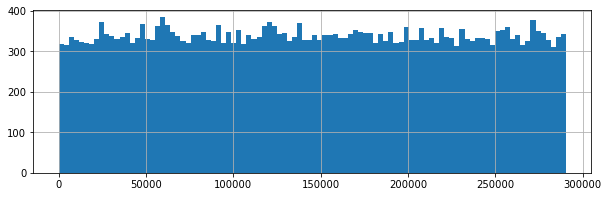

In [23]:
y[y.iloc[:]==1].reset_index()['ID'].hist(bins=100,figsize=(10,3));

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

### 3.4 Random Forest Classifier <a id='3.4_rf'></a>

In [26]:
rf = RandomForestClassifier(random_state=222)

In [27]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 222,
 'verbose': 0,
 'warm_start': False}

In [28]:
param_grid = {'n_estimators': [400, 600, 800],
              'max_depth': [10, 20, None],
              'bootstrap': [True, False]}

rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter = 100,
                               scoring='roc_auc', cv = 3, verbose=2, n_jobs = -1, random_state=333)

rf_cv.fit(X_train,y_train)

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/data/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 51.7min
/data/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 145.5min finished


Best Score:0.7604779486499114
Best Parameters: {'n_estimators': 800, 'max_depth': 20, 'bootstrap': False}


In [30]:
y_pred = rf_cv.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred, target_names=['RF 0','RF 1']))

              precision    recall  f1-score   support

        RF 0       0.80      0.98      0.88     27856
        RF 1       0.73      0.18      0.29      8452

    accuracy                           0.79     36308
   macro avg       0.76      0.58      0.58     36308
weighted avg       0.78      0.79      0.74     36308



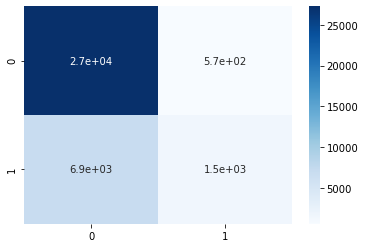

In [32]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,cmap='Blues');

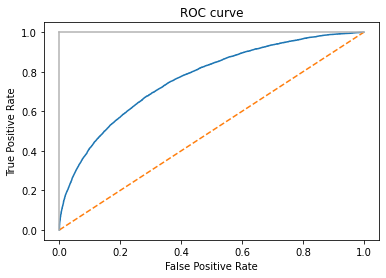

AUC= 0.76563
ROC_AUC_SCORE= 0.76563


In [33]:
y_score = rf_cv.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

# Plot ROC curve
plt.title('ROC curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('AUC=',round(auc(false_positive_rate, true_positive_rate),5))
print('ROC_AUC_SCORE=',round(roc_auc_score(y_test, y_score,average = "weighted"),5))

In [34]:
rf_cv.cv_results_

{'mean_fit_time': array([ 391.23945991,  578.70087616,  750.45786985,  674.36204457,
        1020.07592837, 1351.18583067,  853.77765155, 1260.93477488,
        1611.00538898,  543.89652832,  783.46275465, 1073.24304708,
        1052.60891032, 1568.13733943, 2180.18197282, 1328.57076216,
        1796.11571487, 1902.35151752]),
 'std_fit_time': array([  1.36085774,   2.07357402,  17.71970529,  19.02163862,
         25.93038823,  22.15249473,  10.93420394,  39.92703098,
          4.6971264 ,  16.57806858,   8.57950657,  22.97931321,
          8.69967022,  26.20881267,  23.31782406,  12.50247367,
         69.90021067, 135.23409329]),
 'mean_score_time': array([ 7.03993177,  8.87971568, 11.61016568, 13.16636046, 25.14597503,
        30.77641559, 18.57309214, 27.90620844, 33.57686083,  5.7944177 ,
         8.84369516, 14.35767007, 23.12109637, 30.39391573, 44.52545333,
        24.43280045, 22.92137178, 20.96172134]),
 'std_score_time': array([0.83495259, 0.17892165, 0.26651688, 0.46724684, 

In [35]:
dti = dt_all.select_dtypes(include='int')
dti = dti.drop(i1,axis=1)
dti.shape

(145232, 1402)

In [36]:
y_out = rf_cv.predict_proba(dti)[:,1]
y_out

array([0.2961041 , 0.2874866 , 0.24310763, ..., 0.1241377 , 0.09973627,
       0.10377138])

In [37]:
fout = pd.read_csv('./sample_submission.csv')
fout.head(2)

,ID,target
0,1,0
1,3,0


In [38]:
fout.target = y_out
fout.to_csv('submission-v0.csv', index=False)

#### 3.4.1 Feature importance <a id='3.4.1_fi'></a>

In [39]:
rf_feature_importance = pd.Series(rf_cv.best_estimator_.feature_importances_, index=X.columns)

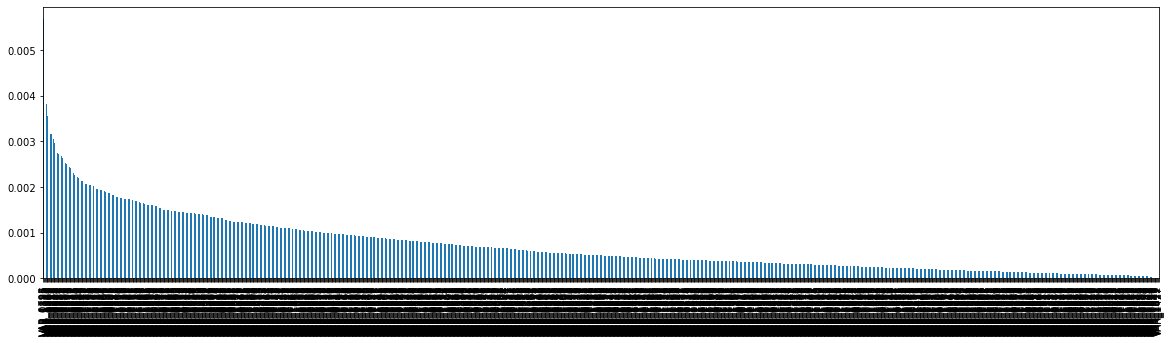

In [57]:
rf_feature_importance.sort_values(ascending=False).plot(kind='bar',figsize=(20,5));

#### 3.4.2 PCA <a id='3.4.2_pca'></a>

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [42]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
pca_scaled = PCA().fit(scaled_X)

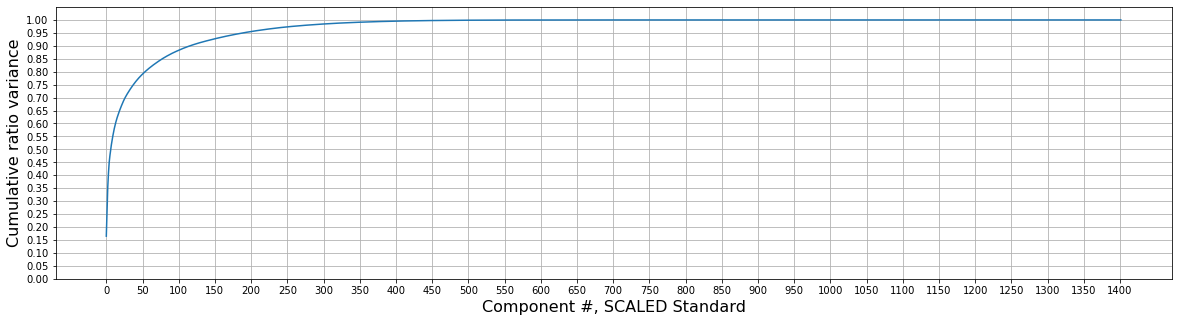

In [58]:
plt.figure(figsize=(20, 5))

n_comp = len(pca_scaled.explained_variance_ratio_)
#n_comp = 320

plt.plot(pca_scaled.explained_variance_ratio_[:n_comp].cumsum())
#plt.plot(pca.explained_variance_ratio_[:n_comp])

plt.xticks(np.arange(0, n_comp, 50))
plt.yticks(np.arange(0, 1.05, 0.05))
#plt.ylim((0.989,1.05))
plt.ylim((0.,1.05))
plt.grid()
plt.xlabel('Component #, SCALED Standard',fontsize=16)
plt.ylabel('Cumulative ratio variance',fontsize=16);

In [44]:
scalerMM = MinMaxScaler()
scaledMM_X = scalerMM.fit_transform(X)
pca_scaledMM = PCA().fit(scaledMM_X)

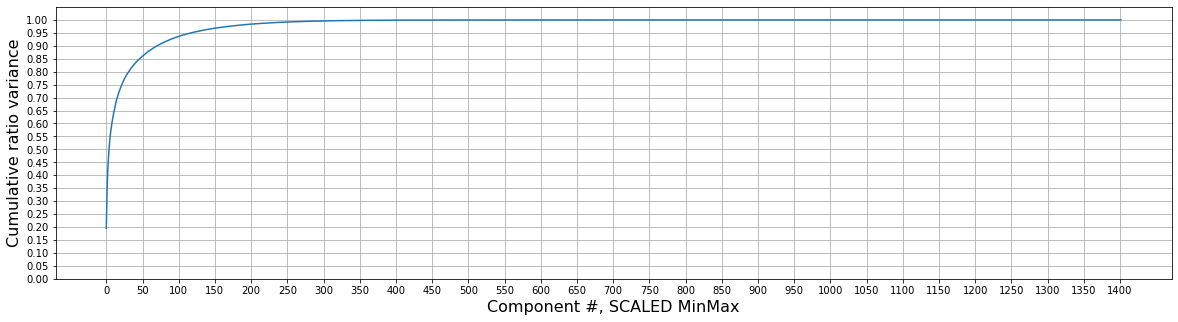

In [59]:
plt.figure(figsize=(20, 5))

n_comp = len(pca_scaledMM.explained_variance_ratio_)

plt.plot(pca_scaledMM.explained_variance_ratio_[:n_comp].cumsum())

plt.xticks(np.arange(0, n_comp, 50))
plt.yticks(np.arange(0, 1.05, 0.05))

plt.ylim((0.,1.05))
plt.grid()
plt.xlabel('Component #, SCALED MinMax',fontsize=16)
plt.ylabel('Cumulative ratio variance',fontsize=16);

### 3.6 XGBoost Classifier <a id='3.6_xgb'></a>

In [46]:
#from xgboost import XGBClassifier
#
#xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc",random_state=222)
#xgb.get_params()

In [47]:
#param_grid_xgb = {'n_estimators': [200, 400, 600, 800],
#                  'max_depth': [5, 10, 20, None],
#                  'eta': [0.03, 0.1,0.3],
#                  'subsample':[0.7]}
#
#xgb_cv = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb, n_iter = 100,
#                               scoring='roc_auc', cv = 3, verbose=2, n_jobs = -1, random_state=333)
#
#xgb_cv.fit(X_train,y_train)
#
#print("Best Score:" + str(xgb_cv.best_score_))
#print("Best Parameters: " + str(xgb_cv.best_params_))

 ## 4. Numerical features / floats  <a id='#4_numerical_floats'></a>

In [111]:
dff = df_all.select_dtypes(include='float')
dff.shape

(145231, 477)

### 4.1 Missing values <a id='4.1_nulls'></a>

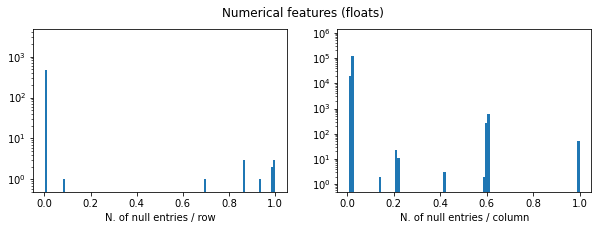

In [109]:
# for columns - sum over rows
# for rows - sum over columns
c= dff.isna().sum(axis=0)/dff.shape[0]
r= dff.isna().sum(axis=1)/dff.shape[1]

fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(c,bins=100) 
ax[1].hist(r,bins=100)

fig.suptitle('Numerical features (floats)')
ax[0].set_yscale('log'); ax[0].set_ylim((0.5,len(c)*10)); ax[0].set_xlabel('N. of null entries / row')
ax[1].set_yscale('log'); ax[1].set_ylim((0.5,len(r)*10)); ax[1].set_xlabel('N. of null entries / column');

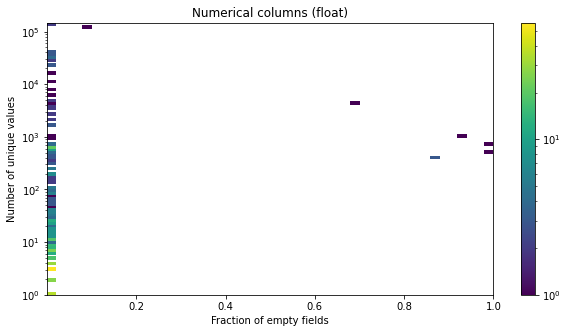

In [53]:
from matplotlib import colors 

fig, ax = plt.subplots(figsize=(10,5))

nu = dff.nunique()
hist, bins= np.histogram(nu.ravel(), bins=100)
logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))
#print(bins)
#print(logbins)

plt.hist2d(c.ravel(),nu.ravel(),bins=(50,logbins),norm = colors.LogNorm())
plt.yscale('log')
plt.colorbar();
plt.title('Numerical columns (float)')
plt.xlabel('Fraction of empty fields')
plt.ylabel('Number of unique values');

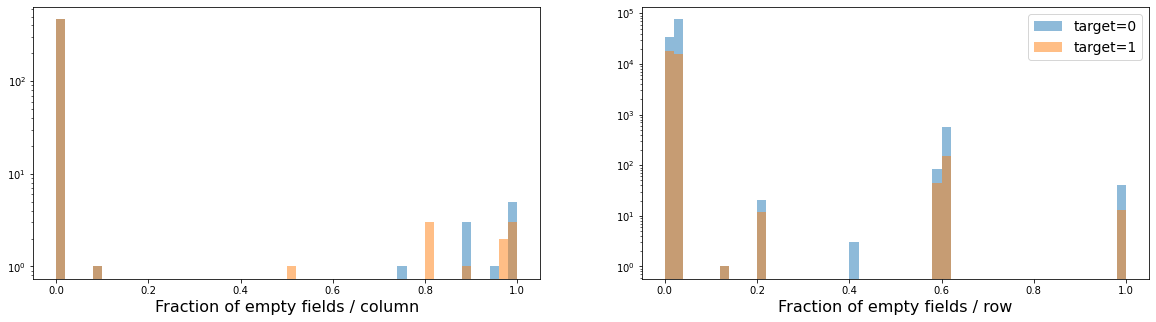

In [60]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

cols = dff.columns

mask = df_all['target'] == 1
dff0 = dff[cols][~mask]
dff1 = dff[cols][mask]

c0= dff0.isna().sum(axis=0)/dff0.shape[0]
c1= dff1.isna().sum(axis=0)/dff1.shape[0]

r0= dff0.isna().sum(axis=1)/dff0.shape[1]
r1= dff1.isna().sum(axis=1)/dff1.shape[1]

ax[0].hist(c0,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=0")
ax[0].hist(c1,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=1")

ax[1].hist(r0,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=0")
ax[1].hist(r1,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=1")

ax[0].set_xlabel('Fraction of empty fields / column',fontsize=16)
ax[1].set_xlabel('Fraction of empty fields / row',fontsize=16)

plt.legend(loc='best',fontsize=14)
plt.show();

In [61]:
sn = dff[cols[c>0.6]].nunique(dropna=False).sort_values(ascending=False)
sn

VAR_0074    4565
VAR_0209    1109
VAR_0205     751
VAR_0206     504
VAR_0211     393
VAR_0210     393
VAR_0208     393
VAR_0840       1
VAR_0213       1
VAR_0207       1
dtype: int64

In [62]:
for ecol in sn.index:
    print(ecol,dff[ecol].unique())

VAR_0074 [  nan 5208. 2487. ... 6820. 6234. 3944.]
VAR_0209 [  nan  583.  492. ... 1144. 1058.  311.]
VAR_0205 [ nan  58. 303.  38. 151. 772.  23. 710. 258. 178. 649. 601. 473.  24.
 322.   7. 643. 502. 121. 489. 265. 217. 233. 338. 119. 187. 429. 412.
 496. 287. 583. 165. 259. 517. 663. 189. 110. 373. 192. 427. 668. 811.
 654. 740. 684. 563. 635. 747. 317. 249. 105. 278. 560. 154. 503. 633.
 628. 218. 531. 475. 598. 603. 346. 253. 602. 698. 656. 302. 274. 354.
 463. 363. 500.  62. 430. 528. 711. 380. 725.  96. 286. 650.  97. 209.
  82. 331. 453. 404. 832. 141. 585. 578. 671. 479. 600. 617. 260. 263.
 242. 318. 536. 632. 753. 310. 252. 519. 661. 172. 526. 342. 559. 238.
 738. 396. 513. 155. 146.  74. 213.  60.  93. 535. 596. 425. 157. 652.
 541. 521. 332. 692. 343. 261.  75. 174. 606. 236. 307. 653.  89. 618.
 334. 269. 114.  76. 678. 741. 300. 817. 534. 728. 207. 577. 118.  91.
 271. 316. 507. 244.  78. 197. 616. 676. 356. 275. 497. 482. 639. 546.
 264.  54.  41. 272. 836. 371. 361. 5

### 4.2 Unique values <a id='4.2_uniques'></a>

In [64]:
nuni = []
nuni_dic = {}

#for col in df.select_dtypes(include='float').columns:
for col in dff.columns:

    nuni.append(dff[col].nunique(dropna=False))
    nuni_dic[col] = dff[col].nunique(dropna=False)

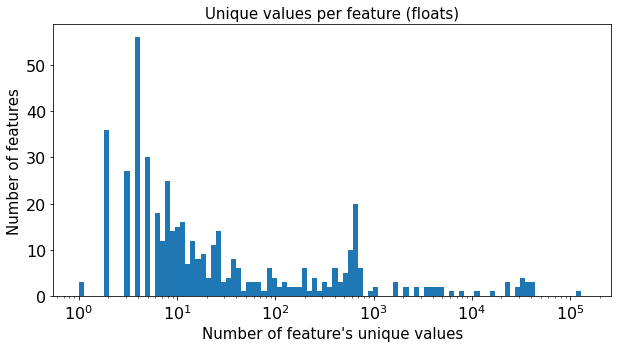

In [65]:
plt.figure(figsize=(10,5))

hist, bins= np.histogram(nuni, bins=100)
logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))

plt.hist(nuni, bins=logbins)
plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Unique values per feature (floats)",fontsize=15)
plt.xlabel("Number of feature's unique values",fontsize=15)
plt.ylabel("Number of features",fontsize=15)
plt.show()

In [66]:
i1 = []
i2 = []
i3 = []
i4 = []
i5 = []
i6 = []

for k,v in nuni_dic.items():
    
    if(v==1):    i1.append(k)
    elif (v==2): i2.append(k)
    elif (v==3): i3.append(k)
    elif (v==4): i4.append(k)
    elif (v==5): i5.append(k)  
    elif (v==6): i6.append(k)

In [67]:
for v in i1:
    print(dff[v].value_counts(dropna=False),'\n ---')

NaN    145231
Name: VAR_0207, dtype: int64 
 ---
NaN    145231
Name: VAR_0213, dtype: int64 
 ---
NaN    145231
Name: VAR_0840, dtype: int64 
 ---


In [68]:
for v in i2:
    print(dff[v].value_counts(dropna=False),'\n ---')

0.0    145175
NaN        56
Name: VAR_0018, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0019, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0020, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0021, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0022, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0023, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0024, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0025, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0026, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0027, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0028, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0029, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0030, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0031, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0032, dtype: int64 
 ---
0.0    145175
NaN        56
Name: VAR_0038, dtype: int6

In [69]:
for v in i3:
    print(dff[v].value_counts(dropna=False),'\n ---')

0.0    145121
NaN        91
1.0        19
Name: VAR_0098, dtype: int64 
 ---
0.0    145136
NaN        91
1.0         4
Name: VAR_0106, dtype: int64 
 ---
0.0    145118
NaN        91
1.0        22
Name: VAR_0114, dtype: int64 
 ---
0.0    145119
NaN        91
1.0        21
Name: VAR_0130, dtype: int64 
 ---
0.0    145121
NaN        91
1.0        19
Name: VAR_0138, dtype: int64 
 ---
0.0    145081
NaN        89
1.0        61
Name: VAR_0180, dtype: int64 
 ---
0.0    145081
NaN        89
1.0        61
Name: VAR_0181, dtype: int64 
 ---
0.0    145081
NaN        89
1.0        61
Name: VAR_0182, dtype: int64 
 ---
0.0    145138
NaN        89
1.0         4
Name: VAR_0191, dtype: int64 
 ---
1.0    143665
NaN       918
0.0       648
Name: VAR_0244, dtype: int64 
 ---
0.0    143985
NaN       918
1.0       328
Name: VAR_0247, dtype: int64 
 ---
0.0    131363
1.0     12950
NaN       918
Name: VAR_0344, dtype: int64 
 ---
0.0    87818
1.0    56495
NaN      918
Name: VAR_0362, dtype: int64 
 ---
0.

In [70]:
for v in i4:
    print(dff[v].value_counts(dropna=False),'\n ---')

1.0    132647
0.0     12476
NaN        91
2.0        17
Name: VAR_0090, dtype: int64 
 ---
1.0    132634
0.0     12471
NaN        91
2.0        35
Name: VAR_0091, dtype: int64 
 ---
0.0    144985
1.0       153
NaN        91
2.0         2
Name: VAR_0099, dtype: int64 
 ---
0.0    145101
NaN        91
1.0        36
2.0         3
Name: VAR_0107, dtype: int64 
 ---
0.0    144981
1.0       156
NaN        91
2.0         3
Name: VAR_0115, dtype: int64 
 ---
1.0    143483
0.0      1633
NaN        91
2.0        24
Name: VAR_0122, dtype: int64 
 ---
0.0    144985
1.0       153
NaN        91
2.0         2
Name: VAR_0139, dtype: int64 
 ---
0.0    144493
1.0       642
NaN        89
2.0         7
Name: VAR_0183, dtype: int64 
 ---
0.0    145131
NaN        89
1.0         9
2.0         2
Name: VAR_0192, dtype: int64 
 ---
 0.0    143925
 NaN       918
 1.0       385
-1.0         3
Name: VAR_0248, dtype: int64 
 ---
 1.0    131847
 0.0     12465
 NaN       918
-1.0         1
Name: VAR_0252, dtype: int

In [71]:
for v in i5:
    print(dff[v].value_counts(dropna=False),'\n ---')

1.0    132575
0.0     12438
2.0       125
NaN        91
3.0         2
Name: VAR_0092, dtype: int64 
 ---
0.0    144867
1.0       250
NaN        91
2.0        20
3.0         3
Name: VAR_0108, dtype: int64 
 ---
0.0    144251
1.0       855
NaN        91
2.0        33
4.0         1
Name: VAR_0116, dtype: int64 
 ---
1.0    143459
0.0      1633
NaN        91
2.0        47
3.0         1
Name: VAR_0123, dtype: int64 
 ---
1.0    143291
0.0      1633
2.0       209
NaN        91
3.0         7
Name: VAR_0124, dtype: int64 
 ---
0.0    144980
1.0       148
NaN        91
2.0        11
3.0         1
Name: VAR_0131, dtype: int64 
 ---
0.0    139870
1.0      4862
2.0       401
NaN        89
3.0         9
Name: VAR_0150, dtype: int64 
 ---
0.0    144246
1.0       860
NaN        89
2.0        35
3.0         1
Name: VAR_0153, dtype: int64 
 ---
0.0    143941
1.0      1126
NaN        89
2.0        69
3.0         6
Name: VAR_0163, dtype: int64 
 ---
0.0    143114
1.0      1841
2.0       167
NaN        89

In [72]:
for v in i6:
    print(dff[v].value_counts(dropna=False),'\n ---')

0.0     144621
1.0        517
NaN         56
2.0         34
3.0          2
12.0         1
Name: VAR_0045, dtype: int64 
 ---
0.0    144294
1.0       813
NaN        91
2.0        31
4.0         1
3.0         1
Name: VAR_0100, dtype: int64 
 ---
0.0    144262
1.0       818
NaN        91
2.0        56
4.0         3
3.0         1
Name: VAR_0140, dtype: int64 
 ---
0.0    143798
1.0      1223
2.0       113
NaN        89
3.0         7
4.0         1
Name: VAR_0146, dtype: int64 
 ---
0.0    142547
1.0      2480
2.0       107
NaN        89
3.0         7
4.0         1
Name: VAR_0184, dtype: int64 
 ---
0.0    140981
1.0      3859
2.0       261
NaN        89
3.0        35
4.0         6
Name: VAR_0185, dtype: int64 
 ---
0.0    139044
1.0      5560
2.0       445
NaN        89
3.0        78
4.0        15
Name: VAR_0186, dtype: int64 
 ---
0.0    145081
NaN        89
1.0        50
2.0         8
3.0         2
6.0         1
Name: VAR_0195, dtype: int64 
 ---
0.0    142918
1.0      1224
2.0       977


### 4.3 Feature engineering  (floats) <a id='4.3_fi'></a>

OK, time to act:

1) remove 3 columns with nan only

2) since nan behaviour different for target=0 and 1, let's replace it by adding a min value -1

In [115]:
dff = dff.drop(i1,axis=1)
dff.shape

(145231, 474)

In [116]:
replace_min = []

for col in dff.columns:
    min = dff[col].min()    
    dff[col] = dff[col].fillna(min - 1)

    replace_min.append(min-1)
    
dff.shape

(145231, 474)

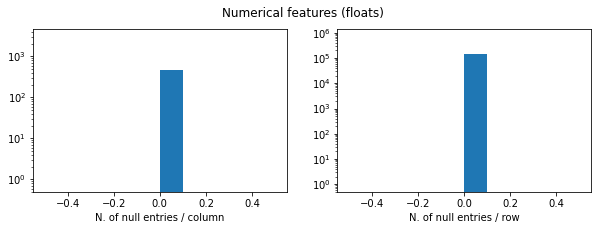

In [118]:
c= dff.isna().sum(axis=0)/dff.shape[0]
r= dff.isna().sum(axis=1)/dff.shape[1]

fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(c) 
ax[1].hist(r)

fig.suptitle('Numerical features (floats)')
ax[0].set_yscale('log'); ax[0].set_ylim((0.5,len(c)*10)); ax[0].set_xlabel('N. of null entries / column')
ax[1].set_yscale('log'); ax[1].set_ylim((0.5,len(r)*10)); ax[1].set_xlabel('N. of null entries / row');

### 4.4 Random Forest Classifier <a id='4.4_rf'></a>

In [119]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(dff, y, test_size=0.25, random_state=111)

In [120]:
rf2 = RandomForestClassifier(random_state=222)

In [121]:
param_grid = {'n_estimators': [800,1000],
              'max_depth': [20, 30, 40],
              'bootstrap': [True, False]}

rf2_cv = RandomizedSearchCV(estimator=rf2, param_distributions=param_grid, n_iter = 100,
                               scoring='roc_auc', cv = 3, verbose=2, n_jobs = -1, random_state=333)

rf2_cv.fit(X_train2,y_train2)

print("Best Score:" + str(rf2_cv.best_score_))
print("Best Parameters: " + str(rf2_cv.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/data/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/data/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 88.3min finished


Best Score:0.6878175525662079
Best Parameters: {'n_estimators': 1000, 'max_depth': 20, 'bootstrap': False}


In [125]:
y_pred2 = rf2_cv.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=['RF 0','RF 1']))

              precision    recall  f1-score   support

        RF 0       0.79      0.97      0.87     27856
        RF 1       0.59      0.14      0.23      8452

    accuracy                           0.78     36308
   macro avg       0.69      0.56      0.55     36308
weighted avg       0.74      0.78      0.72     36308



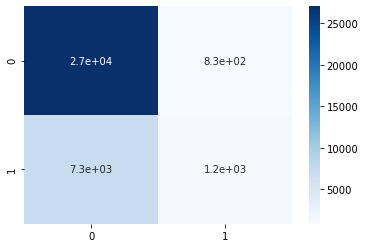

In [126]:
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm,annot=True,cmap='Blues');

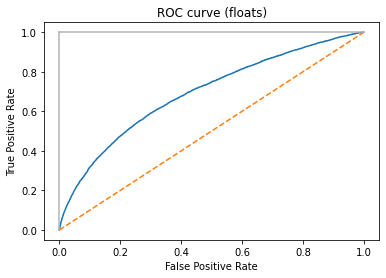

AUC= 0.69225
ROC_AUC_SCORE= 0.69225


In [127]:
y_score2 = rf2_cv.predict_proba(X_test2)[:,1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test2, y_score2)

# Plot ROC curve
plt.title('ROC curve (floats)')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('AUC=',round(auc(false_positive_rate, true_positive_rate),5))
print('ROC_AUC_SCORE=',round(roc_auc_score(y_test2, y_score2,average = "weighted"),5))

In [142]:
dtf = dt_all.select_dtypes(include='float')
dtf.shape

(145232, 477)

In [143]:
dtf = dtf.drop(i1,axis=1)

for i, col in enumerate(dtf.columns):
    dtf[col] = dtf[col].fillna(replace_min[i])
    
dtf.shape

(145232, 474)

In [144]:
y_out = rf2_cv.predict_proba(dtf)[:,1]
y_out

array([0.38696564, 0.48952708, 0.28162431, ..., 0.1097596 , 0.3551267 ,
       0.09504038])

In [145]:
fout.target = y_out
fout.to_csv('submission-v1.csv', index=False)

#### 4.4.1 Feature importance <a id='4.4.1_fi'></a>

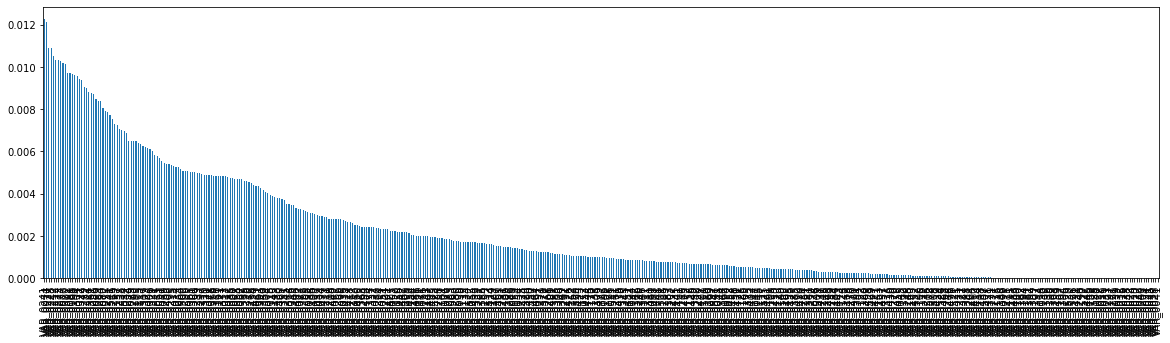

In [146]:
rf2_feature_importance = pd.Series(rf2_cv.best_estimator_.feature_importances_, index=dff.columns)
rf2_feature_importance.sort_values(ascending=False).plot(kind='bar',figsize=(20,5));

#### 4.4.2 PCA <a id='4.4.2_pca'></a>

In [147]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(dff)
pca_scaled = PCA().fit(scaled_X)

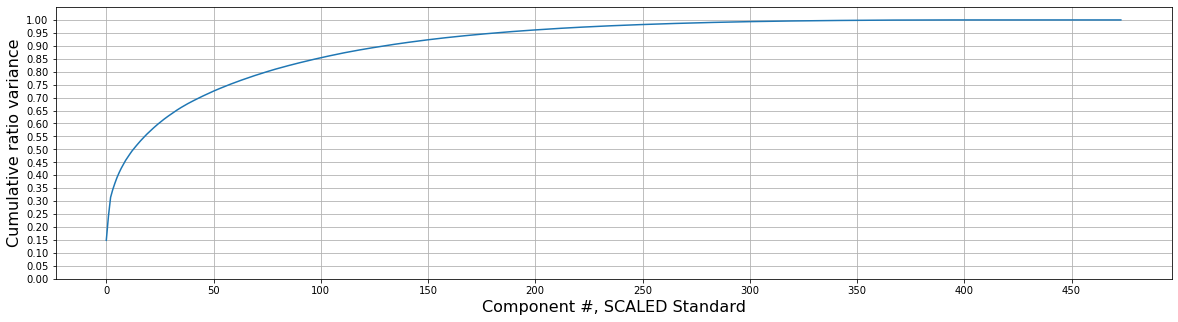

In [148]:
plt.figure(figsize=(20, 5))

n_comp = len(pca_scaled.explained_variance_ratio_)
#n_comp = 320

plt.plot(pca_scaled.explained_variance_ratio_[:n_comp].cumsum())

plt.xticks(np.arange(0, n_comp, 50))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylim((0.,1.05))
plt.grid()
plt.xlabel('Component #, SCALED Standard',fontsize=16)
plt.ylabel('Cumulative ratio variance',fontsize=16);

#### 4.4.3 Kolmogorov-Smirnov test <a id='4.4.3_ks_test'></a>

In [149]:
from scipy import stats

ks = []
pv = []

ks_acc = []
ks_rem = []

for col in dff.columns:
    ks_score, p_val = stats.ks_2samp(dff0[col], dff1[col])

    ks.append(ks_score)
    pv.append(p_val)

    if p_val < 0.005:
        ks_acc.append(ks_score)
    else:
        ks_rem.append(ks_score)

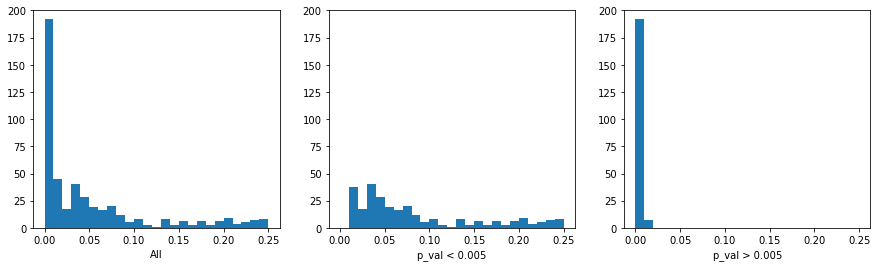

All features: 474 , significant: 275 , insignificant: 199


In [155]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].hist(ks,bins=25,range=(0,0.25))
ax[1].hist(ks_acc,bins=25,range=(0,0.25))
ax[2].hist(ks_rem,bins=25,range=(0,0.25))

ax[0].set_ylim(0,200)
ax[1].set_ylim(0,200)
ax[2].set_ylim(0,200)
                 
ax[0].set_xlabel('All')
ax[1].set_xlabel('p_val < 0.005')
ax[2].set_xlabel('p_val > 0.005')

plt.show()

print('All features:',len(ks),', significant:',len(ks_acc),', insignificant:',len(ks_rem))

#### 4.4.4 Correlation matrix <a id='4.4.4_corr'></a>

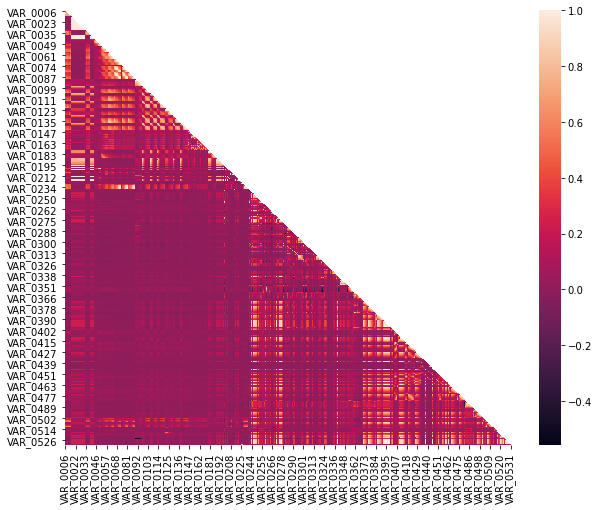

In [152]:
cm = dff.corr()
f, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(cm, dtype=bool))

sns.heatmap(cm,mask=mask);

 ## 5. Categorical features  <a id='#5_categorical'></a>

In [248]:
dfc = df_all.select_dtypes(include='object')
dfc.shape

(145231, 51)

In [249]:
cols = dfc.columns
cols_new = []

for i in range(len(cols)):
    cols_new.append("C-" + str(i))
    
dfc.columns = cols_new

In [283]:
dfc.iloc[:,0:14].dropna().head()

,C-0,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13
ID,,,,,,,,,,,,,,
166,R,N,False,False,False,False,False,False,[],11SEP12:00:00:00,24SEP10:00:00:00,02AUG11:00:00:00,05JUL12:00:00:00,31JAN12:00:00:00
249,R,C,False,False,False,False,False,False,[],01OCT12:00:00:00,02NOV09:00:00:00,05MAY11:00:00:00,05JUN11:00:00:00,01MAR12:00:00:00
604,R,B,False,False,False,False,False,False,[],22JUN12:00:00:00,09NOV11:00:00:00,09NOV11:00:00:00,26MAY12:00:00:00,22FEB12:00:00:00
886,R,N,False,False,False,False,False,False,[],12JUN12:00:00:00,01APR09:00:00:00,01JAN12:00:00:00,16JUN12:00:00:00,29FEB12:00:00:00
3062,H,B,False,False,False,False,False,False,[],07MAR12:00:00:00,06SEP10:00:00:00,12OCT11:00:00:00,09MAR12:00:00:00,02MAR12:00:00:00


In [285]:
dfc.iloc[:,14:22].dropna().head()

,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21
ID,,,,,,,,
249,02FEB12:00:00:00,05APR10:00:00:00,21MAY12:00:00:00,20APR11:00:00:00,13APR12:00:00:00,05APR10:00:00:00,21MAY12:00:00:00,01MAR12:00:00:00
1682,19JUN12:00:00:00,14JUL11:00:00:00,04JAN12:00:00:00,29JUL11:00:00:00,06DEC11:00:00:00,14JUL11:00:00:00,04JAN12:00:00:00,29JUL11:00:00:00
2778,09JUL12:00:00:00,28APR08:00:00:00,03AUG12:00:00:00,02JUL12:00:00:00,10JUL12:00:00:00,28APR08:00:00:00,09AUG12:00:00:00,02JUL12:00:00:00
4805,03OCT12:00:00:00,15NOV10:00:00:00,05JUL11:00:00:00,01JUN11:00:00:00,01JUN11:00:00:00,15NOV10:00:00:00,05JUL11:00:00:00,01JUN11:00:00:00
6296,21DEC11:00:00:00,10SEP07:00:00:00,29MAY12:00:00:00,29JUN11:00:00:00,02APR12:00:00:00,10SEP07:00:00:00,29MAY12:00:00:00,24FEB12:00:00:00


In [297]:
dfc.iloc[:,22:34].dropna().head()

,C-22,C-23,C-24,C-25,C-26,C-27,C-28,C-29,C-30,C-31,C-32,C-33
ID,,,,,,,,,,,,
87489,13APR12:00:00:00,False,BATON ROUGE,BatchInquiry,30JAN14:21:09:00,HRE-Social Security Number-1373,DS,19APR12:02:00:00,C6,False,False,False
113977,23FEB10:00:00:00,False,GREENVILLE,BatchInquiry,30JAN14:23:20:00,HRE-Social Security Number-1747,DS,24MAY12:02:00:00,C6,False,False,False
123414,14APR12:00:00:00,False,MONTGOMERY,BatchInquiry,30JAN14:21:19:00,HRE-Social Security Number-1397,DS,20APR12:02:00:00,C6,False,False,False
127147,03OCT11:00:00:00,False,ALTAMONTE SPRINGS,BatchInquiry,29JAN14:19:55:00,HRE-Social Security Number-15335,DS,24OCT11:02:00:00,C6,False,False,False


In [298]:
dfc.iloc[:,34:51].dropna().head()

,C-34,C-35,C-36,C-37,C-38,C-39,C-40,C-41,C-42,C-43,C-44,C-45,C-46,C-47,C-48,C-49,C-50
ID,,,,,,,,,,,,,,,,,
2,True,True,FL,False,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
4,False,True,CA,False,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
5,True,True,WV,False,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
7,False,True,TX,False,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
8,True,True,IL,False,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH


In [306]:
#a = pd.concat((dfc.nunique(dropna=False),dfc.nunique()),axis=1,ignore_index=True).reset_index()
#a.columns = ['feature','with_nan','w/o_nan']
#a
dfc.nunique(dropna=False)

C-0         3
C-1         4
C-2         2
C-3         2
C-4         2
C-5         2
C-6         2
C-7         2
C-8         2
C-9      1459
C-10     2372
C-11      731
C-12      425
C-13      408
C-14      651
C-15     2146
C-16      854
C-17     1646
C-18     1909
C-19     2164
C-20      946
C-21     1649
C-22     1876
C-23        2
C-24    12386
C-25        2
C-26     1193
C-27       13
C-28        2
C-29      398
C-30        2
C-31        3
C-32        2
C-33        3
C-34        3
C-35        3
C-36       46
C-37        2
C-38       58
C-39        8
C-40        9
C-41       10
C-42       51
C-43        5
C-44        5
C-45        5
C-46     1824
C-47        3
C-48        5
C-49      609
C-50        5
dtype: int64

### 5.1 Missing values <a id='5.1_nulls'></a>

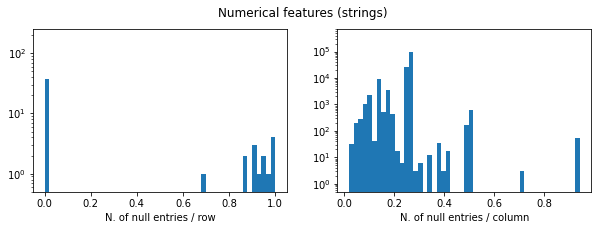

In [206]:
# for columns - sum over rows
# for rows - sum over columns
c= dfc.isna().sum(axis=0)/dfc.shape[0]
r= dfc.isna().sum(axis=1)/dfc.shape[1]

fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(c,bins=50) 
ax[1].hist(r,bins=50)

fig.suptitle('Numerical features (strings)')
ax[0].set_yscale('log'); ax[0].set_ylim((0.5,len(c)*5)); ax[0].set_xlabel('N. of null entries / row')
ax[1].set_yscale('log'); ax[1].set_ylim((0.5,len(r)*5)); ax[1].set_xlabel('N. of null entries / column');

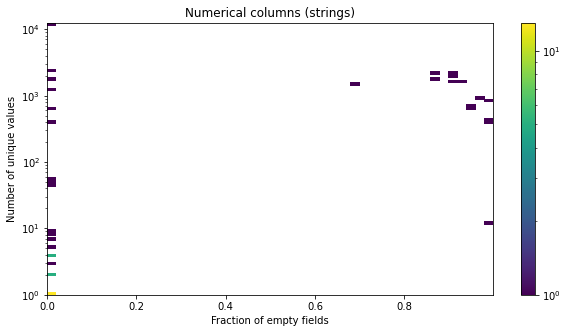

In [188]:
from matplotlib import colors 

fig, ax = plt.subplots(figsize=(10,5))

nu = dfc.nunique()
hist, bins= np.histogram(nu.ravel(), bins=100)
logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))

plt.hist2d(c.ravel(),nu.ravel(),bins=(50,logbins),norm = colors.LogNorm())
plt.yscale('log')
plt.colorbar();
plt.title('Numerical columns (strings)')
plt.xlabel('Fraction of empty fields')
plt.ylabel('Number of unique values');

In [301]:
sn = dfc[cols[c>0.5]].nunique(dropna=False)#.sort_values(ascending=False)
#sn = dfc[cols[c>0.5]].max(axis=1,skipna=True)
sn

C-9     1459
C-11     731
C-12     425
C-13     408
C-14     651
C-15    2146
C-16     854
C-17    1646
C-18    1909
C-19    2164
C-20     946
C-21    1649
C-22    1876
C-27      13
dtype: int64

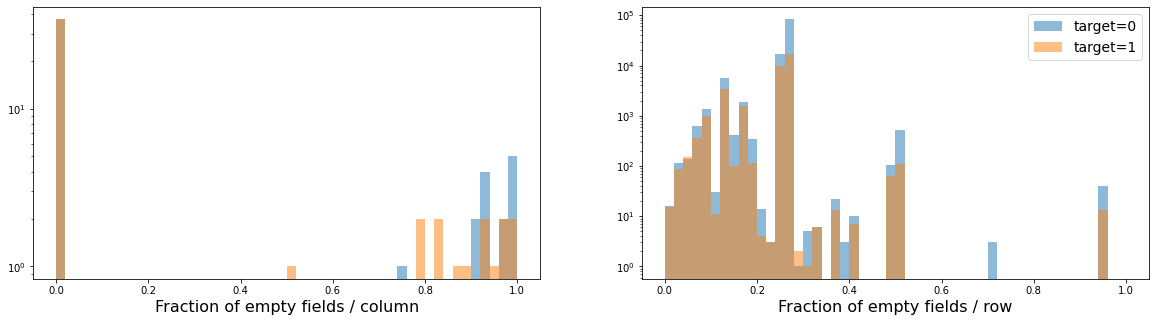

In [264]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

cols = dfc.columns

mask = df_all['target'] == 1
dfc0 = dfc[cols][~mask]
dfc1 = dfc[cols][mask]

c0= dfc0.isna().sum(axis=0)/dfc0.shape[0]
c1= dfc1.isna().sum(axis=0)/dfc1.shape[0]

r0= dfc0.isna().sum(axis=1)/dfc0.shape[1]
r1= dfc1.isna().sum(axis=1)/dfc1.shape[1]

ax[0].hist(c0,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=0")
ax[0].hist(c1,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=1")

ax[1].hist(r0,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=0")
ax[1].hist(r1,bins=50,range=(0.,1.),alpha=0.5,log=True,label="target=1")

ax[0].set_xlabel('Fraction of empty fields / column',fontsize=16)
ax[1].set_xlabel('Fraction of empty fields / row',fontsize=16)

plt.legend(loc='best',fontsize=14)
plt.show();

### 5.2 Unique values <a id='5.2_uniques'></a>

In [254]:
nuni = []
nuni_dic = {}

for col in dfc.columns:
    
    nuni.append(dfc[col].nunique(dropna=False))
    nuni_dic[col] = dfc[col].nunique(dropna=False)

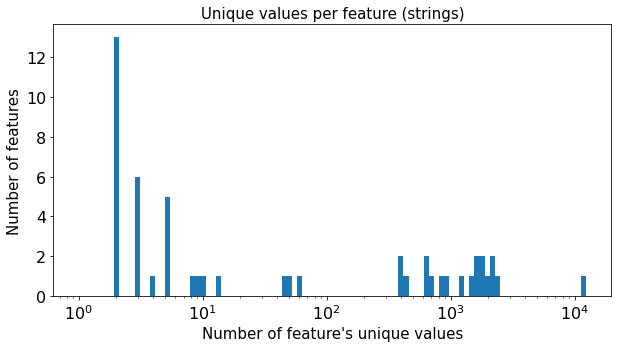

In [255]:
plt.figure(figsize=(10,5))

hist, bins= np.histogram(nuni, bins=100)
logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))

plt.hist(nuni, bins=logbins)
plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Unique values per feature (strings)",fontsize=15)
plt.xlabel("Number of feature's unique values",fontsize=15)
plt.ylabel("Number of features",fontsize=15)
plt.show()

In [257]:
s2 = []
s3 = []
sX = []
sXX = []
sXXX = []
sXXXX = []

for k,v in nuni_dic.items():
    
    if(v==2):      s2.append(k)
    elif (v==3):   s3.append(k)
    elif (v<15):   sX.append(k)
    elif (v<100):  sXX.append(k)
    elif (v<5000): sXXX.append(k)
    else:          sXXXX.append(k)

In [258]:
for v in s2:
    print(dfc[v].value_counts(dropna=False),'\n ---')

False    145175
NaN          56
Name: C-2, dtype: int64 
 ---
False    145175
NaN          56
Name: C-3, dtype: int64 
 ---
False    145175
NaN          56
Name: C-4, dtype: int64 
 ---
False    145175
NaN          56
Name: C-5, dtype: int64 
 ---
False    145175
NaN          56
Name: C-6, dtype: int64 
 ---
False    145175
NaN          56
Name: C-7, dtype: int64 
 ---
[]     145175
NaN        56
Name: C-8, dtype: int64 
 ---
False    145175
NaN          56
Name: C-23, dtype: int64 
 ---
BatchInquiry    145175
NaN                 56
Name: C-25, dtype: int64 
 ---
DS     145175
NaN        56
Name: C-28, dtype: int64 
 ---
C6     145175
NaN        56
Name: C-30, dtype: int64 
 ---
False    145175
NaN          56
Name: C-32, dtype: int64 
 ---
False    145175
NaN          56
Name: C-37, dtype: int64 
 ---


In [259]:
for v in s3:
    print(dfc[v].value_counts(dropna=False),'\n ---')

R    84893
H    59829
Q      509
Name: C-0, dtype: int64 
 ---
False    144703
True        472
NaN          56
Name: C-31, dtype: int64 
 ---
False    145004
True        171
NaN          56
Name: C-33, dtype: int64 
 ---
True     82118
False    63057
NaN         56
Name: C-34, dtype: int64 
 ---
True     144849
False       326
NaN          56
Name: C-35, dtype: int64 
 ---
-1     121461
I       22852
NaN       918
Name: C-47, dtype: int64 
 ---


In [260]:
for v in sX:
    print(dfc[v].value_counts(dropna=False),'\n ---')

B    71449
C    54299
N    16605
S     2878
Name: C-1, dtype: int64 
 ---
NaN                                 145219
HRE-Home Phone-0621                      1
HRE-Social Security Number-18823         1
HRE-Social Security Number-1747          1
HRE-Social Security Number-1397          1
HRE-Social Security Number-15335         1
HRE-Social Security Number-1373          1
HRE-Social Security Number-1855          1
HRE-Social Security Number-2857          1
FSI-0005-1                               1
HRE-Social Security Number-10143         1
HRE-Home Phone-0779                      1
HRE-Social Security Number-1289          1
Name: C-27, dtype: int64 
 ---
S      113607
H       24513
-1       4960
NaN       918
P         637
R         303
F         267
U          26
Name: C-39, dtype: int64 
 ---
S      108830
H       25366
P        6708
-1       2907
NaN       918
R         413
U          54
M          33
F           2
Name: C-40, dtype: int64 
 ---
S      89842
H      26745
-1     135

In [262]:
for v in sXXX:
    print(dfc[v].value_counts(dropna=False),'\n ---')

NaN                 101127
13MAR09:00:00:00       260
12MAR09:00:00:00       218
10JUN11:00:00:00       138
14DEC11:00:00:00       132
                     ...  
02JUN08:00:00:00         1
26FEB09:00:00:00         1
05SEP08:00:00:00         1
06MAR10:00:00:00         1
28OCT08:00:00:00         1
Name: C-9, Length: 1459, dtype: int64 
 ---
22SEP10:00:00:00    1168
23SEP10:00:00:00     957
06DEC11:00:00:00     776
15NOV11:00:00:00     742
22NOV11:00:00:00     706
                    ... 
23AUG05:00:00:00       1
14DEC08:00:00:00       1
14DEC05:00:00:00       1
25SEP06:00:00:00       1
19APR05:00:00:00       1
Name: C-10, Length: 2372, dtype: int64 
 ---
NaN                 139361
12DEC11:00:00:00        45
13DEC11:00:00:00        34
02JUL12:00:00:00        33
20SEP11:00:00:00        31
                     ...  
09FEB09:00:00:00         1
29JUL12:00:00:00         1
10JUN10:00:00:00         1
23MAR11:00:00:00         1
13NOV10:00:00:00         1
Name: C-11, Length: 731, dtype: int64 
 --

### 5.3 Feature engineering  (strings) <a id='5.3_fi'></a>

Based on the investigations above, the 51 string features can be divided into the following classes:
    * columns C0-8,23,25,28,37,39-45,47,48,50 - with low number of unique values. They can be processes using LabelEncoder or OneHotEncoder.
    
    * columns C9-22,26,29,30-35 - contain datetime data. The dates can be converted into year, month, day of the month, day of the week etc; one could also calculate a difference between selected dates.
    
    * column C24 - contains more than 12k names of US locations (cities/towns). With an additional information about their population from CENSUS (add link) one could convert those fields into just a few corresponding to different city/town sizes.
    
    * column C27 - 12 fields contain social security or phone numbers, while the remaining fields (145k) have missing values. One could convert this feature to a binary one (1/0 for info given/missing), or perhaps even remove the whole column from the dataset.
    
    * columns C36 and C38 - encode the US state labels. C38 is not always the same as C36, so one could replace it with a binary information (different/the same).
    
    * columns C46 and C39 - list various profession/position names and have about 1.8k and 600 unique values, respectively. Most of the professions are listed only once or twice in the dataset. Settining a threshold on the minimal number of apperences could limit the number of labels to not more than 100 or 150 (see the reduction below for a threshold of 5), then apply LabelEncoder or OneHotEncoder.

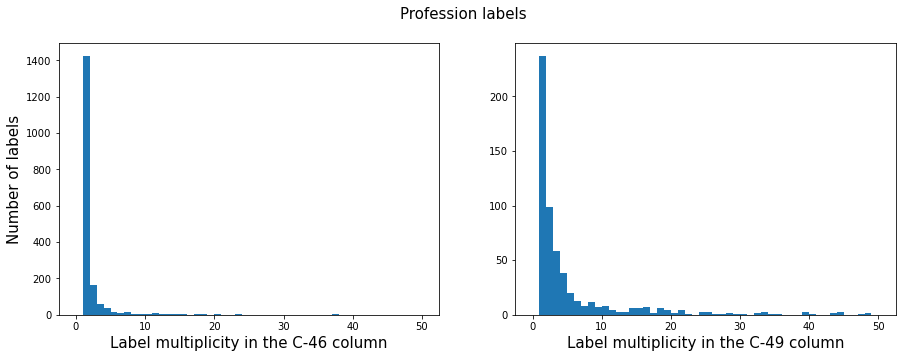

In [379]:
fit, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(dfc['C-46'].value_counts(dropna=False).values,range=(0,50),log=0,bins=50)
ax[1].hist(dfc['C-49'].value_counts(dropna=False).values,range=(0,50),log=0,bins=50)

ax[0].set_xlabel('Label multiplicity in the C-46 column',fontsize=15)
ax[1].set_xlabel('Label multiplicity in the C-49 column',fontsize=15)  

ax[0].set_ylabel('Number of labels',fontsize=15)


plt.suptitle('Profession labels',fontsize=15)
plt.show()

In [377]:
thres = 5
frequent_46 = dfc['C-46'].value_counts(dropna=False).values>thres
frequent_49 = dfc['C-49'].value_counts(dropna=False).values>thres
print('C-46:',dfc['C-46'].nunique(dropna=False),'reduced to',frequent_46.sum())
print('C-49:',dfc['C-49'].nunique(dropna=False),'reduced to',frequent_49.sum())

C-46: 1824 reduced to 119
C-49: 609 reduced to 157
